In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from mlp import MLPClassifier


def generate_data():
    # Generate class 0 with 1 cluster
    X0, y0 = make_classification(
        n_samples=500,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=2,
        weights=[1.0, 0.0],  # only class 0
        class_sep=1.8,
        random_state=42,
        flip_y=0,
    )

    # Generate class 1 with 2 clusters
    X1, y1 = make_classification(
        n_samples=500,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=2,
        n_classes=2,
        weights=[0.0, 1.0],  # only class 1
        class_sep=2.5,
        random_state=24,
        flip_y=0,
    )

    # Combine
    X = np.vstack((X0, X1))
    y = np.hstack((y0, y1))

    # Shuffle
    rng = np.random.RandomState(42)
    idx = rng.permutation(len(y))
    X, y = X[idx], y[idx]
    return X, y


def train_test_split(X, y, test_size=0.2, seed=0):
    rng = np.random.RandomState(seed)
    m = X.shape[0]
    idx = rng.permutation(m)
    m_test = int(m * test_size)
    test_idx = idx[:m_test]
    train_idx = idx[m_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


def plot_data(X, y, title="Dataset"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", s=12, label="Class 0 (1 cluster)")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="red", s=12, label="Class 1 (2 clusters)")
    plt.legend()
    plt.title(title)
    plt.tight_layout()


def plot_decision_boundary(model, X, y, title="Decision boundary"):
    # Create a grid over the feature space
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)
    if probs.shape[1] == 1:
        Z = (probs > 0.5).astype(int).reshape(xx.shape)
    else:
        Z = np.argmax(probs, axis=1).reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5], colors=["blue", "red"])  # binary
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", s=10, label="Class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="red", s=10, label="Class 1")
    plt.legend()
    plt.title(title)
    plt.tight_layout()

Test accuracy: 99.00%


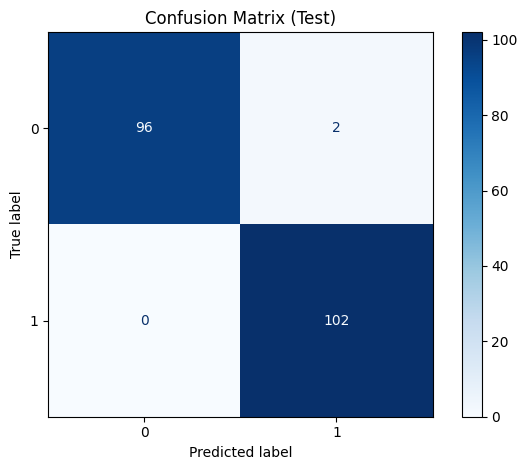

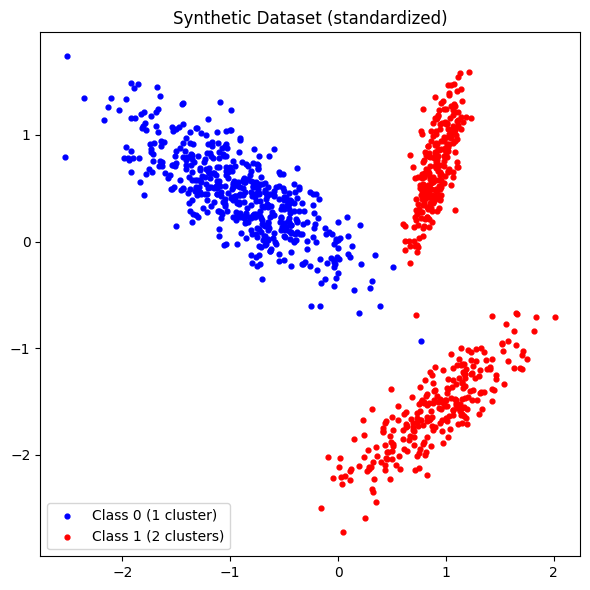

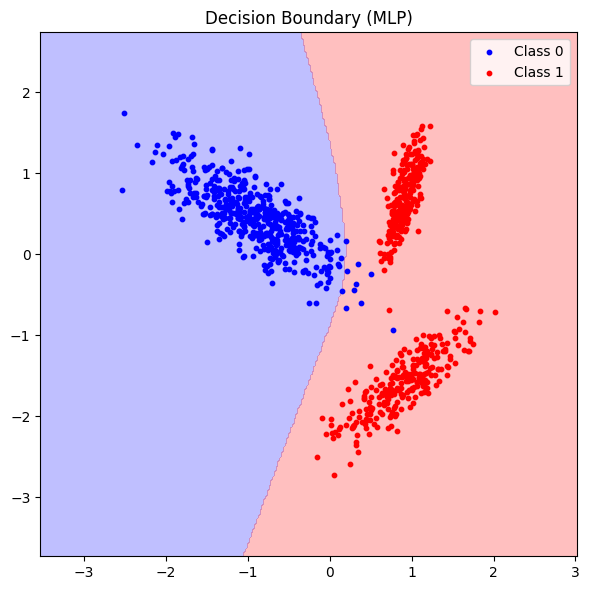

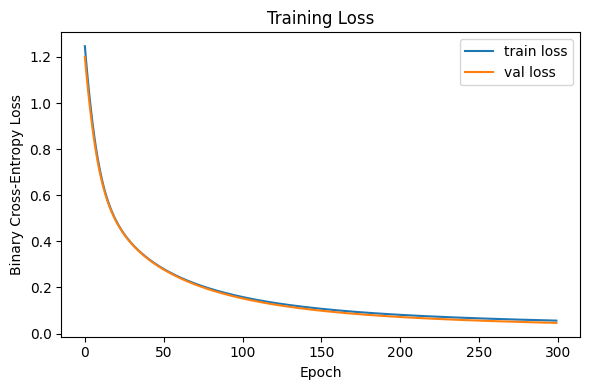

In [2]:

def exercicio_2():
    # 1) Generate and split data
    X, y = generate_data()
    # Standardize (helps training)
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=1)

    model = MLPClassifier(layer_sizes=[2, 16, 1], lr=0.05, epochs=300, scale=0.5, verbose=False, seed=7)

    model.fit(X_train, y_train, track_loss=True, X_val=X_test, y_val=y_test)

    losses = model.history_.get("loss", [])
    val_losses = model.history_.get("val_loss", [])

    # 3) Evaluate on test
    y_pred_test = model.predict(X_test)  # (m,1)
    acc = accuracy_score(y_test.flatten(), y_pred_test.flatten())
    print(f"Test accuracy: {acc * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(y_test.flatten(), y_pred_test.flatten())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()

    # 4) Visualizations
    plot_data(X, y, title="Synthetic Dataset (standardized)")
    plot_decision_boundary(model, X, y, title="Decision Boundary (MLP)")

    # 5) Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="train loss")
    if len(val_losses) == len(losses) and len(val_losses) > 0:
        plt.plot(val_losses, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.tight_layout()

    plt.show()


exercicio_2()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from mlp import MLPClassifier


def generate_multiclass_data(total_samples=1500, random_state=42):
    # Split samples per class (roughly balanced)
    n0 = total_samples // 3
    n1 = total_samples // 3
    n2 = total_samples - n0 - n1

    # Class 0 with 2 clusters
    X0, y0 = make_classification(
        n_samples=n0,
        n_features=4,
        n_informative=4,
        n_redundant=0,
        n_classes=3,
        n_clusters_per_class=2,
        weights=[1.0, 0.0, 0.0],  # only class index 0
        random_state=random_state,
        class_sep=3,
    )
    y0[:] = 0

    # Class 1 with 3 clusters
    X1, y1 = make_classification(
        n_samples=n1,
        n_features=4,
        n_informative=4,
        n_redundant=0,
        n_classes=3,
        n_clusters_per_class=3,
        weights=[0.0, 1.0, 0.0],  # only class index 1
        random_state=random_state + 1,
        class_sep=3,
    )
    y1[:] = 1

    # Class 2 with 4 clusters
    X2, y2 = make_classification(
        n_samples=n2,
        n_features=4,
        n_informative=4,
        n_redundant=0,
        n_classes=3,
        n_clusters_per_class=4,
        weights=[0.0, 0.0, 1.0],  # only class index 2
        random_state=random_state + 2,
        class_sep=3,
    )
    y2[:] = 2

    # Combine and shuffle
    X = np.vstack([X0, X1, X2])
    y = np.concatenate([y0, y1, y2])
    rng = np.random.RandomState(random_state)
    idx = rng.permutation(len(y))
    X, y = X[idx], y[idx]
    return X, y


def train_test_split(X, y, test_size=0.2, seed=0):
    rng = np.random.RandomState(seed)
    m = X.shape[0]
    idx = rng.permutation(m)
    m_test = int(m * test_size)
    test_idx = idx[:m_test]
    train_idx = idx[m_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


def visualize_pca(X, y_true, y_pred=None, title_prefix=""):
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(12, 5))

    # True labels
    plt.subplot(1, 2, 1)
    plt.scatter(X2[:, 0], X2[:, 1], c=y_true, cmap="tab10", s=10)
    plt.title(f"{title_prefix}PCA - True labels")

    # Predicted labels
    if y_pred is not None:
        plt.subplot(1, 2, 2)
        plt.scatter(X2[:, 0], X2[:, 1], c=y_pred, cmap="tab10", s=10)
        plt.title(f"{title_prefix}PCA - Predicted labels")

    plt.tight_layout()


Test accuracy (multiclass): 96.67%


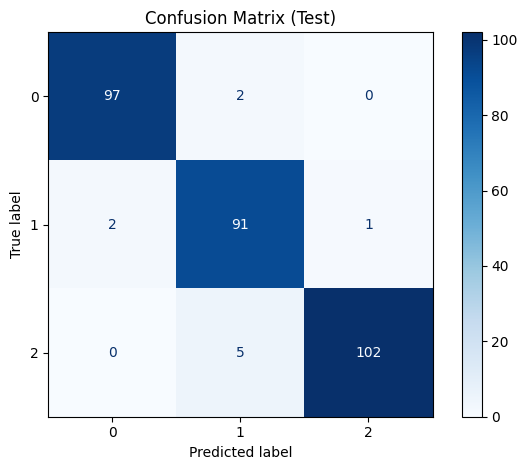

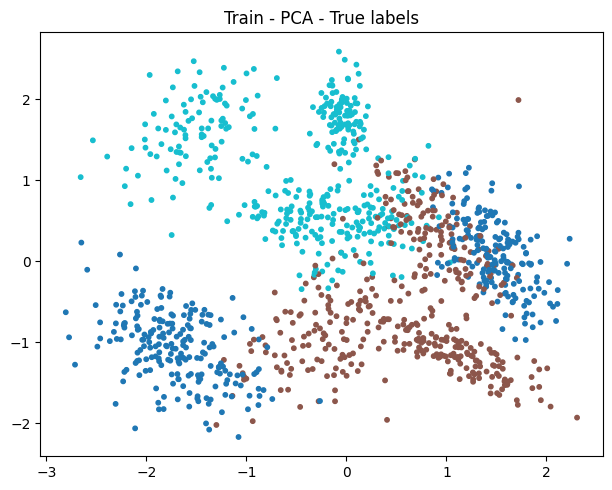

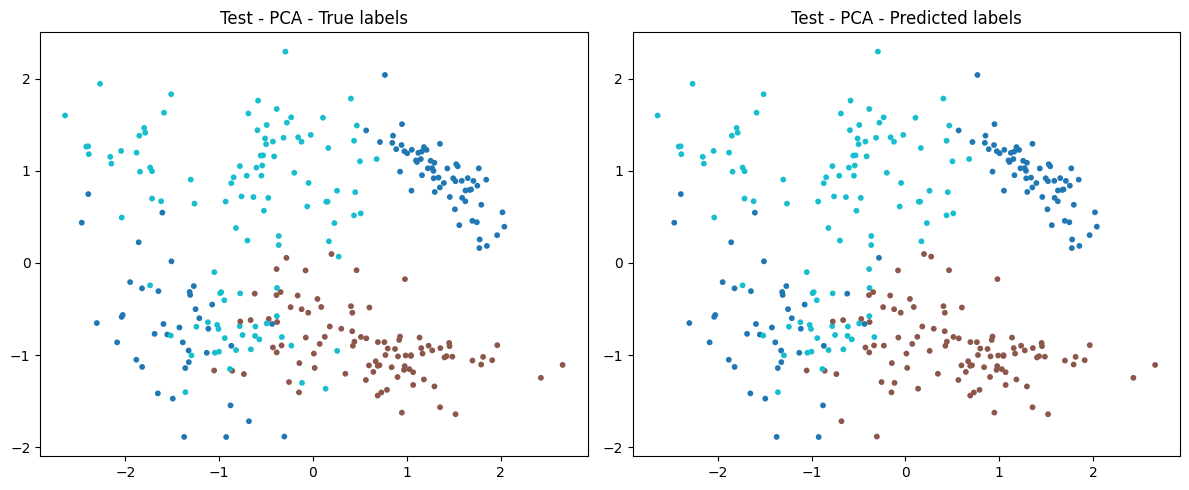

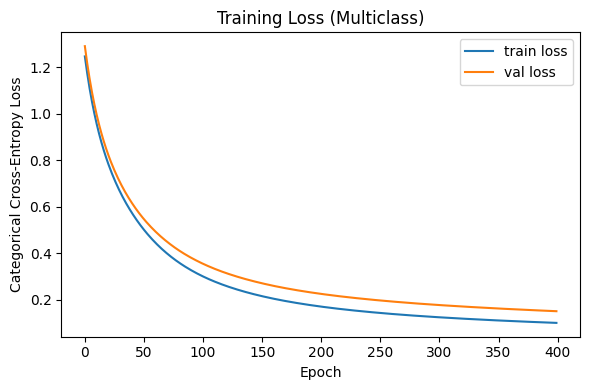

In [4]:


def exercicio_3():
    # 1) Generate and split data (80/20)
    X, y = generate_multiclass_data(total_samples=1500, random_state=42)

    # Standardize
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=1)

    model = MLPClassifier(layer_sizes=[4, 16, 3], lr=0.05, epochs=400, scale=0.4, verbose=False, seed=7)
    model.fit(X_train, y_train, track_loss=True, X_val=X_test, y_val=y_test)

    # 3) Evaluate
    proba_test = model.predict_proba(X_test)
    y_pred_test = np.argmax(proba_test, axis=1).reshape(-1, 1)
    acc = accuracy_score(y_test.flatten(), y_pred_test.flatten())
    print(f"Test accuracy (multiclass): {acc * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(y_test.flatten(), y_pred_test.flatten())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()

    # 4) Visualizations (optional): PCA 2D of train and test with predictions
    visualize_pca(X_train, y_train, title_prefix="Train - ")
    visualize_pca(X_test, y_test, y_pred=y_pred_test.flatten(), title_prefix="Test - ")

    # 5) Plot training/validation loss
    losses = model.history_.get("loss", [])
    val_losses = model.history_.get("val_loss", [])
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="train loss")
    if len(val_losses) == len(losses) and len(val_losses) > 0:
        plt.plot(val_losses, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross-Entropy Loss")
    plt.title("Training Loss (Multiclass)")
    plt.legend()
    plt.tight_layout()

    plt.show()

exercicio_3()

Test accuracy (multiclass): 97.00%


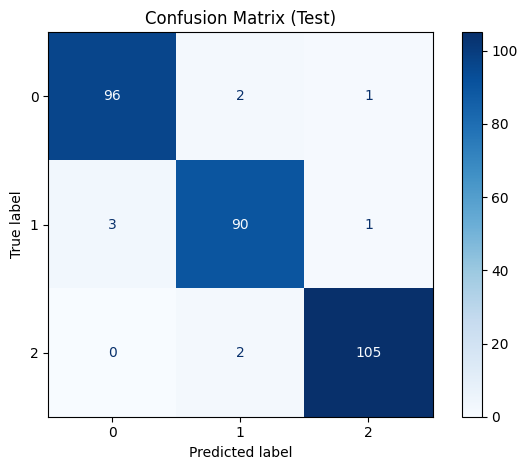

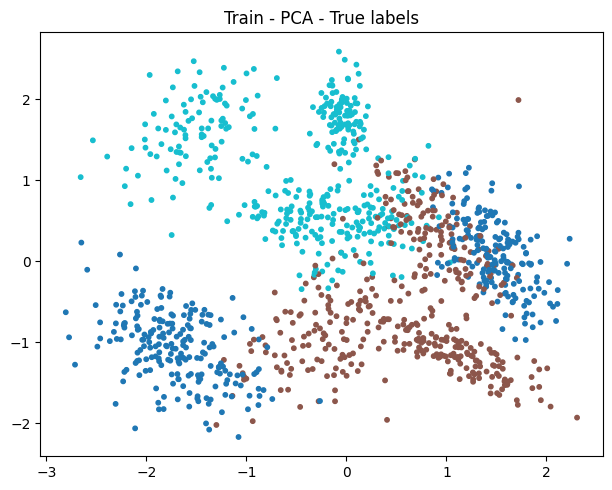

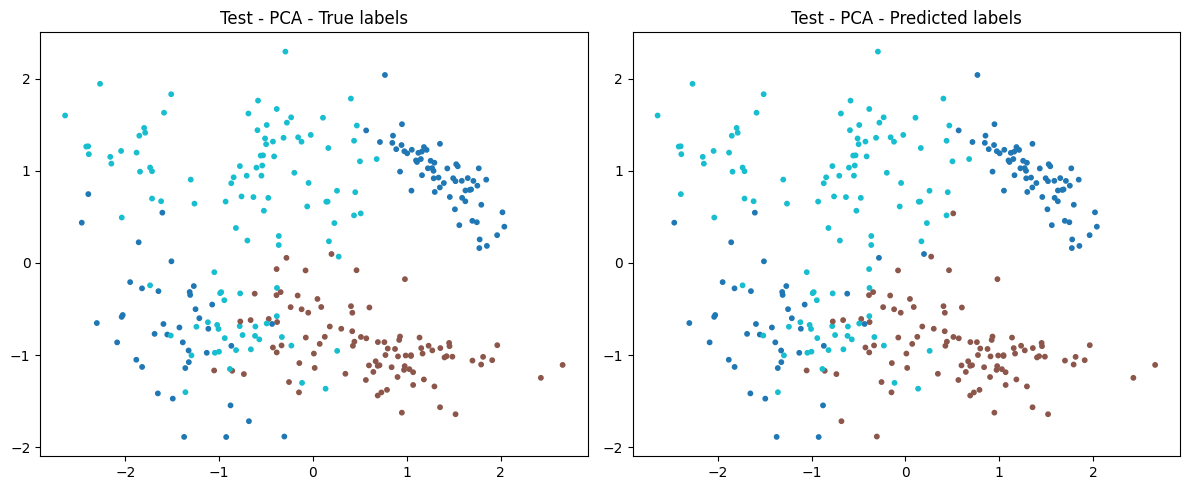

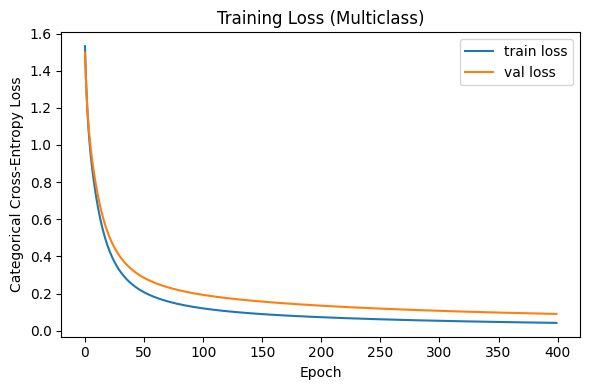

In [5]:


def exercicio_4():
    # 1) Generate and split data (80/20)
    X, y = generate_multiclass_data(total_samples=1500, random_state=42)

    # Standardize
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=1)

    model = MLPClassifier(layer_sizes=[4, 16, 32, 3], lr=0.05, epochs=400, scale=0.4, verbose=False, seed=7)
    model.fit(X_train, y_train, track_loss=True, X_val=X_test, y_val=y_test)

    # 3) Evaluate
    proba_test = model.predict_proba(X_test)
    y_pred_test = np.argmax(proba_test, axis=1).reshape(-1, 1)
    acc = accuracy_score(y_test.flatten(), y_pred_test.flatten())
    print(f"Test accuracy (multiclass): {acc * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(y_test.flatten(), y_pred_test.flatten())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()

    # 4) Visualizations (optional): PCA 2D of train and test with predictions
    visualize_pca(X_train, y_train, title_prefix="Train - ")
    visualize_pca(X_test, y_test, y_pred=y_pred_test.flatten(), title_prefix="Test - ")

    # 5) Plot training/validation loss
    losses = model.history_.get("loss", [])
    val_losses = model.history_.get("val_loss", [])
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="train loss")
    if len(val_losses) == len(losses) and len(val_losses) > 0:
        plt.plot(val_losses, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross-Entropy Loss")
    plt.title("Training Loss (Multiclass)")
    plt.legend()
    plt.tight_layout()

    plt.show()


exercicio_4()